## テクニカル分析指標

[FXトレーダーが良く使うテクニカル指標](https://www.fxciao.com/fx-data/enquete/641/)より

|順位|テクニカル指標|割合|
|---|---|---|
|1位	|移動平均線	|36.6％|
|2位	|ボリンジャーバンド|	17.1％|
|3位	|MACD	|13.2％|
|4位	|RSI|	8.4％|
|5位	|一目均衡表|	8.4％|
|6位	|ストキャスティクス|	7.1％|
|7位	|フィボナッチ	|2.9％|
|8位|	その他|	6.3％|


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.xkcd()
def str2time(string):
    return datetime.strptime(string, '%Y/%m/%d')
# df = pd.read_csv("day14-3765-2017.csv")
df_orig = pd.read_csv("stock_nikkei_3yrs.csv")
df_orig.index = df_orig.date.apply(str2time)
df_orig = df_orig.sort_index(ascending=True)
df_orig.head()

,date,open,high,low,close
date,,,,,
2015-01-05,2015/1/5,17325.68,17540.92,17219.22,17408.71
2015-01-06,2015/1/6,17101.58,17111.36,16881.73,16883.19
2015-01-07,2015/1/7,16808.26,16974.61,16808.26,16885.33
2015-01-08,2015/1/8,17067.40,17243.71,17016.09,17167.10
2015-01-09,2015/1/9,17318.74,17342.65,17129.53,17197.73


C:\Users\imaimai\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


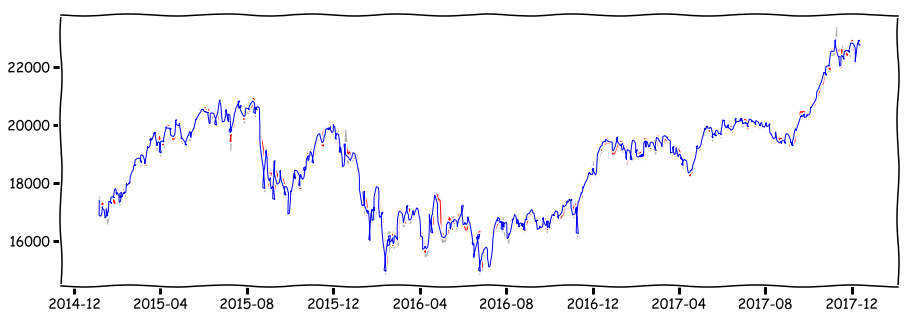

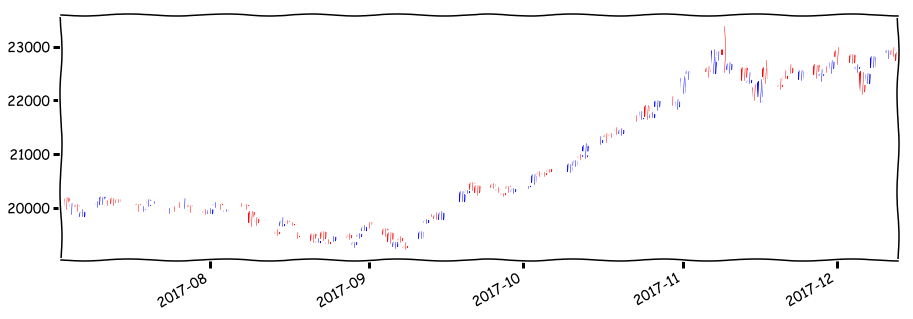

In [2]:
# ローソク足
plt.figure(figsize=(15,5))
plt.plot(df_orig.index,df_orig.open,"-",lw=1,color="red")
plt.plot(df_orig.index,df_orig.close,"-",lw=1,color="blue")
plt.fill_between(df_orig.index, df_orig.low,df_orig.high,color="gray",alpha=0.5)
# tool for finance
import matplotlib.finance as mpf
from matplotlib.dates import date2num
df = df_orig[df_orig.index >= datetime(2017,7,1)]
df_ohlc = pd.DataFrame(df[["open","high","low","close"]])
xdate = [x.date() for x in df_ohlc.index] #Timestamp -> datetime
ohlc = np.vstack((date2num(xdate), df_ohlc.values.T)).T #datetime -> float

fig = plt.figure(figsize=(15,5))
ax = plt.subplot()
mpf.candlestick_ohlc(ax, ohlc, width=0.7, colorup='b', colordown='r')
ax.grid() #グリッド表示
ax.set_xlim(xdate[0], xdate[-1]) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット

## ゴールデンクロス、デッドクロス
> "ゴールデンクロス"は株価が下落した後に短期の移動平均線が、長期の移動平均線を下から上に抜ける現象をいいます。逆に"デッドクロス"は株価が上昇した後に短期の移動平均線が、長期の移動平均線を上から下に抜ける現象をいいます。

- 日足の場合、短期が25日、長期が75日
- 週足の場合、短期が13週、長期が26週


2015/2/20:DEAD CROSS
2015/3/9:GOLDEN CROSS
2015/8/25:DEAD CROSS
2016/11/30:GOLDEN CROSS
2016/2/25:DEAD CROSS
2016/5/25:GOLDEN CROSS
2016/5/27:DEAD CROSS
2016/8/17:GOLDEN CROSS
2017/2/23:DEAD CROSS
2017/5/23:GOLDEN CROSS
2017/8/23:DEAD CROSS
2017/9/4:GOLDEN CROSS


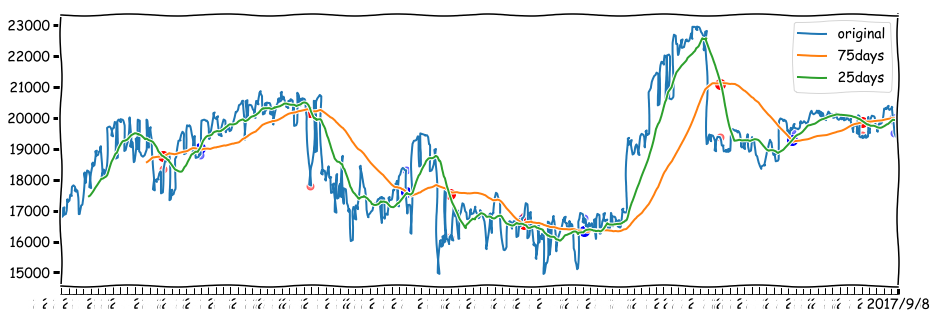

In [3]:
df1 = df_orig.sort_values(by="date")
df1["ma25"] = df1.close.rolling(window=25).mean()
df1["ma75"] = df1.close.rolling(window=75).mean()
df1["diff"] = df1.ma25-df1.ma75
# df1 = df.date.apply(datetime.timestamp())
df1["unixtime"] = [datetime.timestamp(t) for t in df_orig.index]
plt.figure(figsize=(15,5))



# line and Moving Average
plt.plot(df1.date, df1.close,label="original")
plt.plot(df1.date, df1.ma75,label="75days")
plt.plot(df1.date, df1.ma25,label="25days")
plt.xlim(df1.iloc[0]["date"], df1.iloc[-1]["date"])


#Cross
for i in range(1, len(df1)):
    if df1.iloc[i-1]["diff"] < 0 and df1.iloc[i]["diff"] > 0:
        print("{}:GOLDEN CROSS".format(df1.iloc[i]["date"]))
        plt.scatter(df1.iloc[i]["date"],df1.iloc[i]["ma25"],marker="o",s=100,color="b")
        plt.scatter(df1.iloc[i]["date"],df1.iloc[i]["close"],marker="o",s=50,color="b",alpha=0.5)

    if df1.iloc[i-1]["diff"] > 0 and df1.iloc[i]["diff"] < 0:
        print("{}:DEAD CROSS".format(df1.iloc[i]["date"]))
        plt.scatter(df1.iloc[i]["date"],df1.iloc[i]["ma25"],marker="o",s=100,color="r")
        plt.scatter(df1.iloc[i]["date"],df1.iloc[i]["close"],marker="o",s=50,color="r",alpha=0.5)
plt.legend()

## ボリンジャーバンド
$1\sigma, 2\sigma, 3\sigma$線を移動平均に引く

- $1\sigma$ : 67%の確率でそこに収まる
- $2\sigma$ : 95%
- $3\sigma$ : 99%

正規分布を仮定しているので、
ここから外れた = 釣り合いが破れているということ。

不安定だが、売買のチャンスともいえる

In [4]:
def Bollinger(df,window=25):
    df1 = df.copy()
    df1["ma"] = df1.close.rolling(window=window).mean()
    df1["sigma"] =  df1.close.rolling(window=window).std()
    df1["ma+2sigma"] = df1.ma + 2*df1.sigma
    df1["ma-2sigma"] = df1.ma - 2*df1.sigma
    df1["diffplus"] = df1.close - df1["ma+2sigma"] 
    df1["diffminus"] = df1["ma-2sigma"] - df1.close

    print(df1[df1["diffplus"]>0].index)
    s_up = df1[df1["diffplus"]>0]["close"]
    s_down = df1[df1["diffminus"]>0]["close"]

    plt.figure(figsize=(15,5))
    plt.scatter(s_up.index, s_up.values,marker="x",s=100,color="blue")
    plt.scatter(s_down.index, s_down.values,marker="x",s=100,color="red")
    xdate = [x.date() for x in df1.index]
    plt.plot(xdate, df1.close.values,label="close",color="b",alpha=0.8)
    plt.plot(xdate,df1.ma.values,label="{}ma".format(window))
    plt.fill_between(xdate, df1.ma-df1.sigma,df1.ma+df1.sigma,color="red", alpha=0.7, label="$1\sigma$")
    plt.fill_between(xdate, df1.ma-2*df1.sigma,df1.ma+2*df1.sigma,color="red", alpha=0.3, label="$2\sigma$")
#     plt.fill_between(xdate, df1.ma-3*df1.sigma,df1.ma+3*df1.sigma,color="red", alpha=0.3, label="$3\sigma$")    

    plt.legend()
    plt.xlim(xdate[0],xdate[-1])

DatetimeIndex(['2015-02-23', '2015-02-24', '2015-02-26', '2015-06-23',
               '2015-06-24', '2015-11-09', '2015-11-10', '2016-07-19',
               '2016-10-20', '2016-10-25', '2017-05-08', '2017-05-09',
               '2017-05-10', '2017-09-19', '2017-09-20', '2017-09-21',
               '2017-10-23', '2017-10-24', '2017-11-07'],
              dtype='datetime64[ns]', name='date', freq=None)


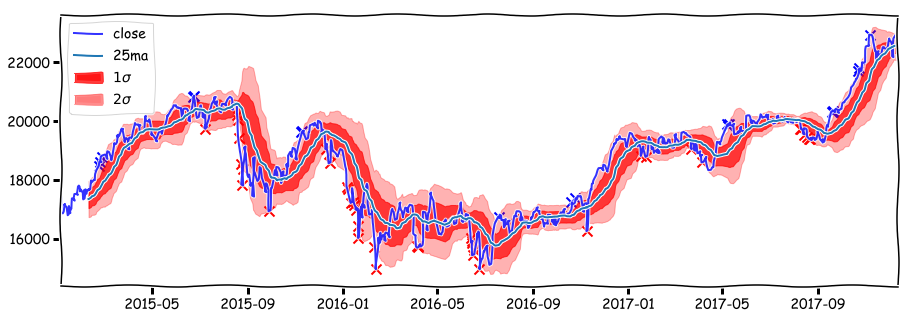

In [5]:
Bollinger(df_orig,window=25)

## RSI

[参考](https://kabu.com/investment/guide/technical/08.html?FontSize=2)

|線|性質|
|---|---|
|転換線|(9日間の高値+9日間の安値)÷2|
|基準線|(26日間の高値+26日間の安値)÷2|
|先行スパン1|(転換線+基準線)÷2を26日先|
|先行スパン2|(52日間の高値+52日間の安値)÷2を26日先|
|遅行スパン|当日の終値を26日前|

売買の目安としてはRSIの数値が70%以上になると買われ過ぎゾーン、逆に30%以下になると売られ過ぎゾーンに入るとされています。
そして、それぞれのゾーンに入った後に反転した動きになったところで買われ過ぎゾーンの時は“売り”を、売られ過ぎゾーンの時は“買い”を考えるとされています。
つまり、RSIの冒頭で述べました「買われ過ぎ」、「売られ過ぎ」を感覚的なものではなく数値で把握するというものです。上図のグラフを見て確認してみてください。

In [6]:
def plot_RSI(df,window):
    diff = df_orig.close.diff(periods=1).values
    xdate = [x.date() for x in df_orig.index]
    RSI = []
    for i in range(window+1,len(xdate)):
        neg = 0
        pos = 0
        for value in diff[i-window:i+1]:
            if value > 0:
                pos += value
            if value < 0:
                neg += value
        pos_ave = pos/window
        neg_ave = np.abs(neg/window)
        rsi = pos_ave/(pos_ave+neg_ave)*100
        RSI.append(rsi)
    #RSIのグラフ描画
    plt.plot(xdate[window+1:], RSI,label="RSI {}".format(window),lw=2.5,alpha=0.6)
    plt.xlim(xdate[window+1],xdate[-1])
    plt.ylim(0,100)
    plt.legend()

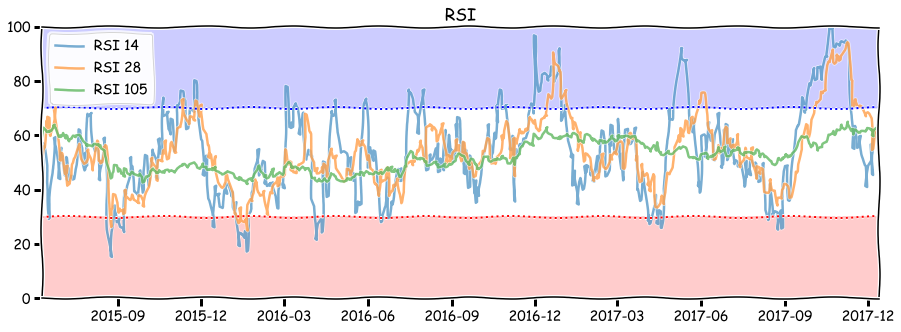

In [7]:
xdate = [x.date() for x in df_orig.index]
plt.figure(figsize=(15,5))
plt.title("RSI")
plot_RSI(df_orig,window=14)
plot_RSI(df_orig,window=28)
plot_RSI(df_orig,window=105)
plt.fill_between(xdate,np.ones(len(xdate))*30,color="red",alpha=0.2)
plt.fill_between(xdate,np.ones(len(xdate))*70,np.ones(len(xdate))*100,color="blue",alpha=0.2)
plt.plot(xdate,np.ones(len(xdate))*30,color="red",linestyle="dotted")
plt.plot(xdate,np.ones(len(xdate))*70,color="blue",linestyle="dotted")
plt.show()

## 一目均衡表

(735603.0, 736676.0)

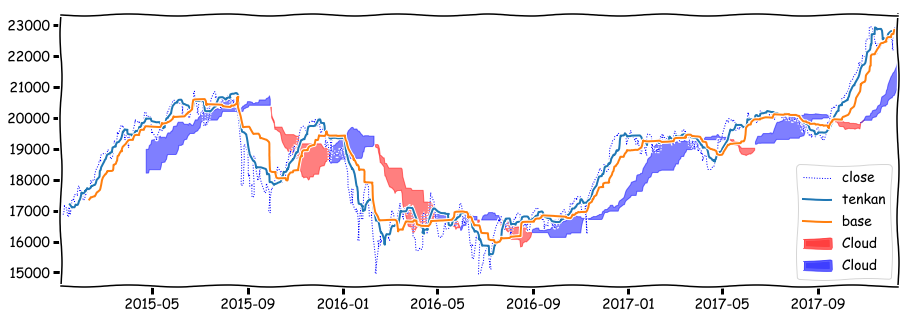

In [8]:

df_orig = pd.read_csv("stock_nikkei_3yrs.csv")
df_orig.index = df_orig.date.apply(str2time)
df_orig = df_orig.sort_index(ascending=True)

max_9 = df_orig.high.rolling(window=9).max()
min_9 = df_orig.high.rolling(window=9).min()
df_orig["tenkan"] = (max_9+min_9)/2
df_orig["base"] = (df_orig.high.rolling(window=26).max()+df_orig.high.rolling(window=26).min())/2
xdate = [x.date() for x in df_orig.index]

plt.figure(figsize=(15,5))
plt.plot(xdate, df_orig.close,color="b",lw=1,linestyle="dotted")
plt.plot(xdate, df_orig.tenkan,label="tenkan")
plt.plot(xdate, df_orig.base,label="base")
senkou1 = ((df_orig.tenkan+df_orig.base)/2).iloc[:-26]
senkou2 = ((df_orig.high.rolling(window=52).max()+df_orig.high.rolling(window=52).min())/2).iloc[:-26]
plt.fill_between(xdate[26:], senkou1, senkou2, where=senkou2 >= senkou1, color="red",alpha=0.5,label="Cloud")
plt.fill_between(xdate[26:], senkou2, senkou1, where=senkou2 <= senkou1, color="blue",alpha=0.5,label="Cloud")
plt.legend()
plt.xlim(xdate[0],xdate[-1])
